# **Netflix Movie Recommendation Engine Using SVD**

## **Problem Statement:**
Netflix collects a massive volume of user–movie rating data, but users often struggle to discover movies that match their individual preferences due to the vast content library. The challenge is to leverage historical user rating data to accurately predict user preferences and provide personalized movie recommendations.

In this project, the objective is to build a collaborative filtering–based recommendation system using the Netflix Prize Dataset and the Singular Value Decomposition (SVD) algorithm. The system aims to identify latent user and movie features from sparse rating data, predict missing ratings, and recommend movies that users are most likely to enjoy. Model performance is evaluated using metrics such as RMSE, ensuring reliable and accurate recommendations that can enhance user engagement and viewing experience.

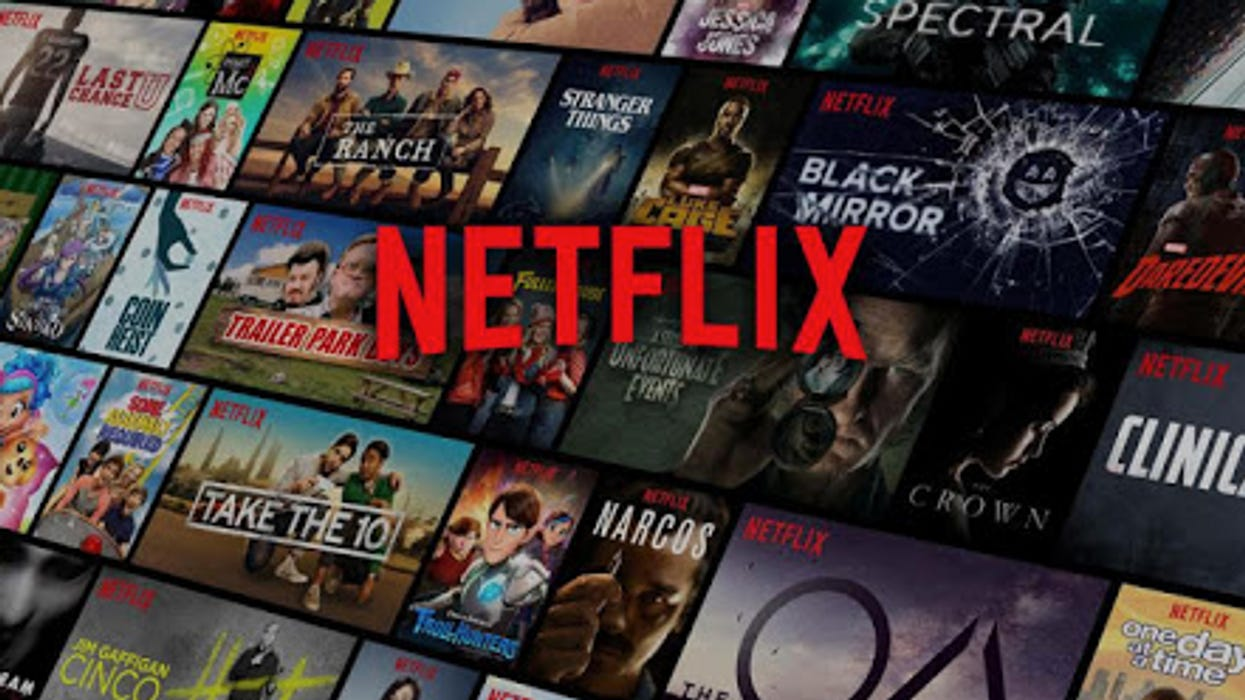

<Figure size 640x480 with 0 Axes>

In [1]:
from IPython.display import Image, display
import matplotlib.pyplot as plt

display(Image(filename=r"D:\Shivudu\Project\Netflix\d6978598-9443-4619-9bf6-af7303821f3e_1245x700.jpg"))
plt.tight_layout()
plt.show()

## **Import necessary Libraries**

In [2]:
#Importing Required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## **Load Data**

In [3]:
#loading the Data
df = pd.read_csv(r"D:\Shivudu\Project\Netflix\combined_data_1.txt", encoding = 'latin1')
df

,,1:
1488844,3.0,2005-09-06
822109,5.0,2005-05-13
885013,4.0,2005-10-19
30878,4.0,2005-12-26
823519,3.0,2004-05-03
...,...,...
2591364,2.0,2005-02-16
1791000,2.0,2005-02-10
512536,5.0,2005-07-27
988963,3.0,2005-12-20


In [4]:
dataset = pd.read_csv(r"D:\Shivudu\Project\Netflix\combined_data_1.txt", header=None, names=['Cust_ID', 'Rating', 'Date'], usecols =[0,1,2])
dataset

,Cust_ID,Rating,Date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26
...,...,...,...
24058258,2591364,2.0,2005-02-16
24058259,1791000,2.0,2005-02-10
24058260,512536,5.0,2005-07-27
24058261,988963,3.0,2005-12-20


In [5]:
#Lets check the shape/size of data
dataset.shape

(24058263, 3)

In [6]:
dataset.dtypes

Cust_ID     object
Rating     float64
Date        object
dtype: object

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058263 entries, 0 to 24058262
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Cust_ID  object 
 1   Rating   float64
 2   Date     object 
dtypes: float64(1), object(2)
memory usage: 550.7+ MB


## **Exploratory Data Analysis**

In [8]:
#Calculating that how many times each rating value (1–5 stars) was given by users
dataset.groupby('Rating')['Rating'].agg(['count'])

,count
Rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


In [9]:
dataset.isnull().sum()

Cust_ID       0
Rating     4499
Date       4499
dtype: int64

from the above we can observe that the rating and Date cotains the null values where MovieID is present in Cust_ID column

In [10]:
#Calculating the total no of Movies exists in our Dataset
movie_count = dataset.isnull().sum()[1]
movie_count

4499

In [11]:
#Calculating the total no of Users exists in our Dataset
cust_count = dataset['Cust_ID'].nunique()
cust_count

475257

In [12]:
#Total no of ratings given by the users
rating_count = dataset['Rating'].count()
rating_count

24053764

#### Lets Extract Movie ID Column

Since the Movie IDs are available within the Ratings data, we will extract the Movie IDs and create a new Movie_ID column with respect to each Customer ID and its corresponding ratings.

In [13]:
movie_id = None
for idx, row in dataset.iterrows():
  if pd.isna(row["Rating"]):
    movie_id = row["Cust_ID"]
  dataset.at[idx, "Movie_ID"] = movie_id

In [14]:
dataset

,Cust_ID,Rating,Date,Movie_ID
0,1:,NaN,NaN,1:
1,1488844,3.0,2005-09-06,1:
2,822109,5.0,2005-05-13,1:
3,885013,4.0,2005-10-19,1:
4,30878,4.0,2005-12-26,1:
...,...,...,...,...
24058258,2591364,2.0,2005-02-16,4499:
24058259,1791000,2.0,2005-02-10,4499:
24058260,512536,5.0,2005-07-27,4499:
24058261,988963,3.0,2005-12-20,4499:


In [15]:
from tqdm import tqdm
tqdm.pandas()
dataset["Movie_ID"] = dataset["Movie_ID"].str.replace(":", "")

In [16]:
dataset

,Cust_ID,Rating,Date,Movie_ID
0,1:,NaN,NaN,1
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
...,...,...,...,...
24058258,2591364,2.0,2005-02-16,4499
24058259,1791000,2.0,2005-02-10,4499
24058260,512536,5.0,2005-07-27,4499
24058261,988963,3.0,2005-12-20,4499


In [17]:
#Let's check if any duplicates are present in dataset
dataset.duplicated().sum()

0

In [18]:
print("Before:", dataset.shape)
print("Exact duplicates:", dataset.duplicated().sum())
print("After:", dataset.drop_duplicates().shape)

Before: (24058263, 4)
Exact duplicates: 0
After: (24058263, 4)


In [19]:
dataset.shape

(24058263, 4)

In [20]:
dataset.describe()

,Rating
count,2.405376e+07
mean,3.599634e+00
std,1.086118e+00
min,1.000000e+00
25%,3.000000e+00
50%,4.000000e+00
75%,4.000000e+00
max,5.000000e+00


In [21]:
dataset.describe(include='object')

,Cust_ID,Date,Movie_ID
count,24058263,24053764,24058263
unique,475257,2182,4499
top,305344,2005-01-19,1905
freq,4467,180428,193942


In [22]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058263 entries, 0 to 24058262
Data columns (total 4 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Cust_ID   object 
 1   Rating    float64
 2   Date      object 
 3   Movie_ID  object 
dtypes: float64(1), object(3)
memory usage: 734.2+ MB


##### Lets change the dataset of columns into appropriate formats

In [23]:
dataset['Movie_ID'] = dataset['Movie_ID'].astype(int)

In [24]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058263 entries, 0 to 24058262
Data columns (total 4 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Cust_ID   object 
 1   Rating    float64
 2   Date      object 
 3   Movie_ID  int32  
dtypes: float64(1), int32(1), object(2)
memory usage: 642.4+ MB


In [25]:
dataset.isnull().sum()

Cust_ID        0
Rating      4499
Date        4499
Movie_ID       0
dtype: int64

In [26]:
dataset.dropna(inplace=True)

In [27]:
dataset.isnull().sum()

Cust_ID     0
Rating      0
Date        0
Movie_ID    0
dtype: int64

In [28]:
dataset['Cust_ID'] = dataset['Cust_ID'].astype(int)

In [29]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24053764 entries, 1 to 24058262
Data columns (total 4 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Cust_ID   int32  
 1   Rating    float64
 2   Date      object 
 3   Movie_ID  int32  
dtypes: float64(1), int32(2), object(1)
memory usage: 734.1+ MB


### **Visulaisation**

##### Let's Visualise the distribution of ratings in our dataset

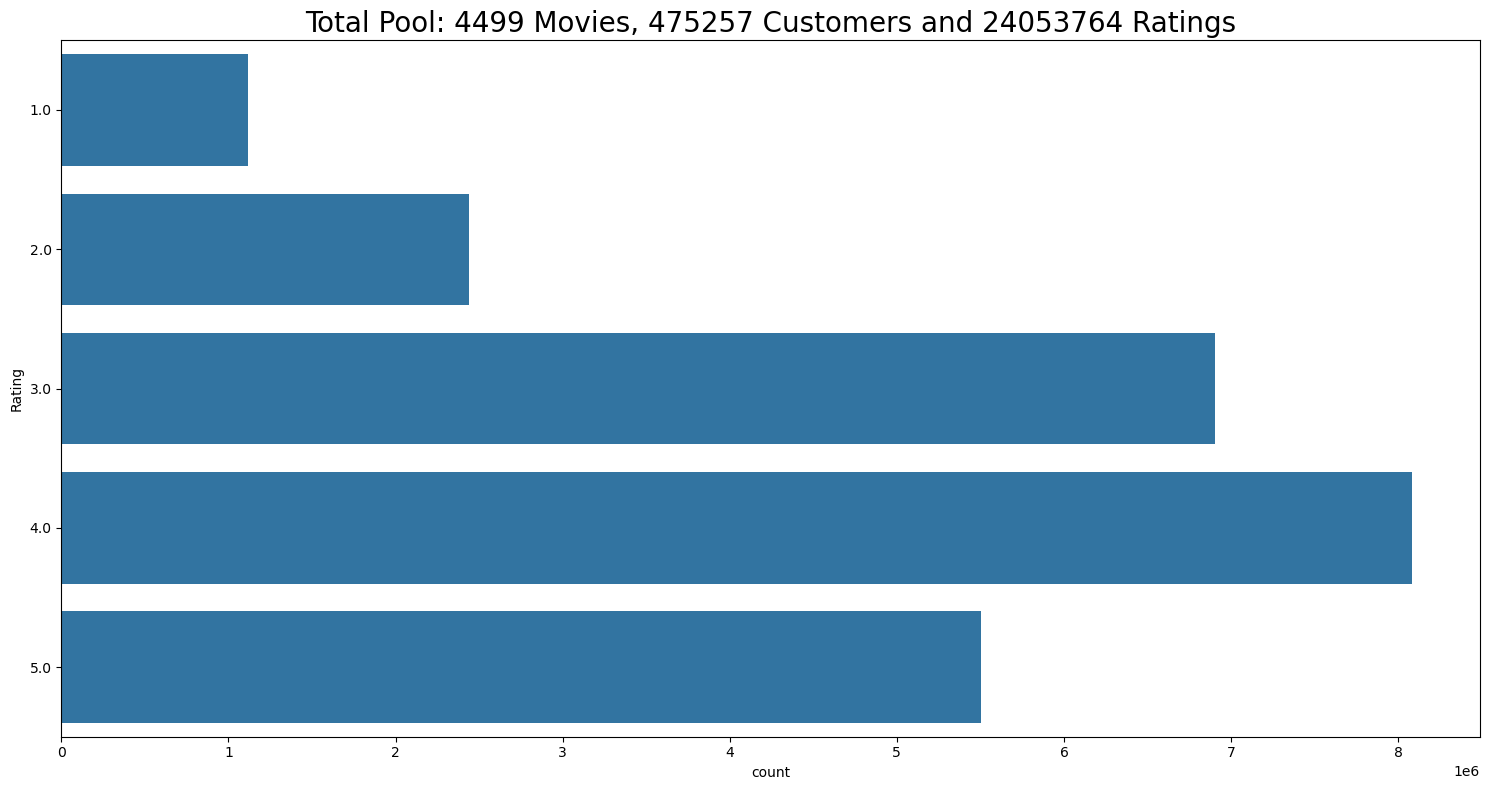

In [30]:
plt.figure(figsize=(15,8))
sns.countplot(data = dataset, y = 'Rating')
plt.title(f'Total Pool: {movie_count} Movies, {cust_count} Customers and {rating_count} Ratings', fontsize=20)
plt.tight_layout()
plt.show()

**Observations:**
- 4-star ratings are the most frequent, indicating that most users feel strong level of positive with the movies followed by 3 and 5.
- 3 star ratings are the second highest, showing that most users feel neutral to moderately satisfied.
- 1-star ratings are the least common, meaning relatively few users strongly disliked the movies.

##### lets count the movie wise no. of ratings given and try to visualise the same

In [31]:
dataset_movie_summary = dataset.groupby('Movie_ID')['Rating'].agg(['count'])
dataset_movie_summary

,count
Movie_ID,
1,547
2,145
3,2012
4,142
5,1140
...,...
4495,614
4496,9519
4497,714


In [32]:
#Lets visualise the Top 25 Most Rated Movies 
top_25 = dataset_movie_summary.sort_values('count', ascending=False).iloc[:25]
top_25

,count
Movie_ID,
1905,193941
2152,162597
3860,160454
4432,156183
571,154832
3938,153996
4306,151292
2452,149866
1962,145519


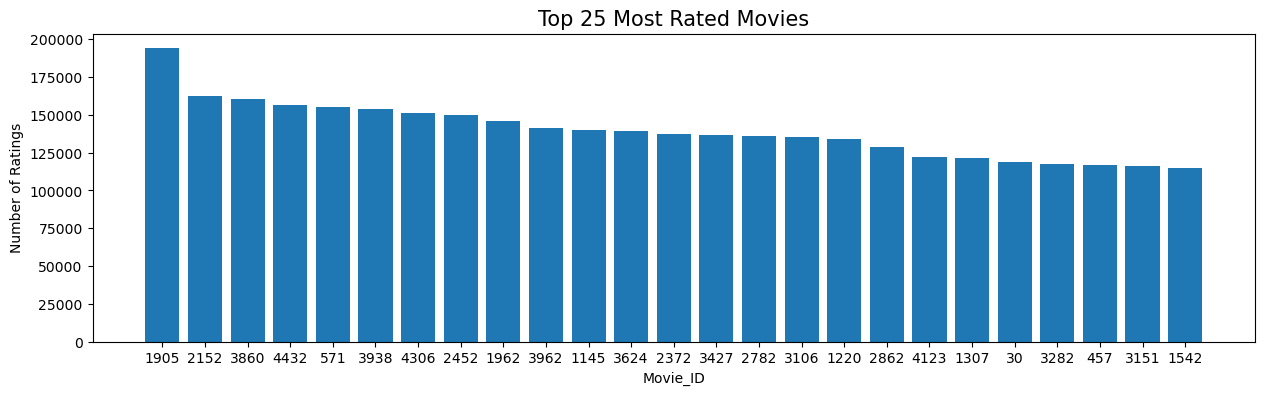

In [33]:
plt.figure(figsize=(15, 4))
plt.bar(top_25.index.astype(str), top_25['count'])
plt.xlabel('Movie_ID')
plt.ylabel('Number of Ratings')
plt.title('Top 25 Most Rated Movies', fontsize=15)
plt.show()


##### Lets check the highest 5 star rated movies given and try to visualise the same

In [34]:
top5_rated = dataset[dataset['Rating']==5].groupby('Movie_ID')['Rating'].agg(['count']).sort_values(['count'], ascending=False)
top5_rated

,count
Movie_ID,
2452,94655
1905,82549
3962,79447
4306,74790
2782,71154
...,...
3695,1
1016,1
1952,1


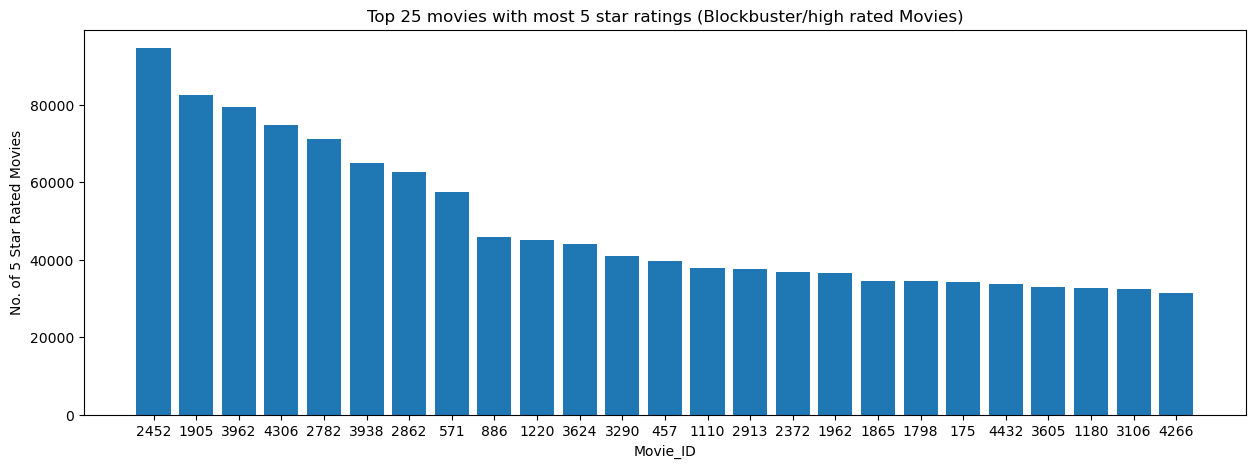

In [35]:
#lets visualise top 25 movies which got highest 5 star ratings
plt.figure(figsize=(15,5))
plt.bar(top5_rated.head(25).index.astype(str), top5_rated['count'].head(25))
plt.xlabel('Movie_ID')
plt.ylabel('No. of 5 Star Rated Movies')
plt.title('Top 25 movies with most 5 star ratings (Blockbuster/high rated Movies)')
plt.show()

##### Lets check the highest 1 star rated movies given and try to visualise the same

In [36]:
top1_rated = dataset[dataset['Rating']==1].groupby('Movie_ID')['Rating'].agg(['count']).sort_values('count', ascending=False)
top1_rated

,count
Movie_ID,
3151,13365
1145,12194
2152,8855
4123,8375
3756,8334
...,...
1422,2
4373,2
3656,2


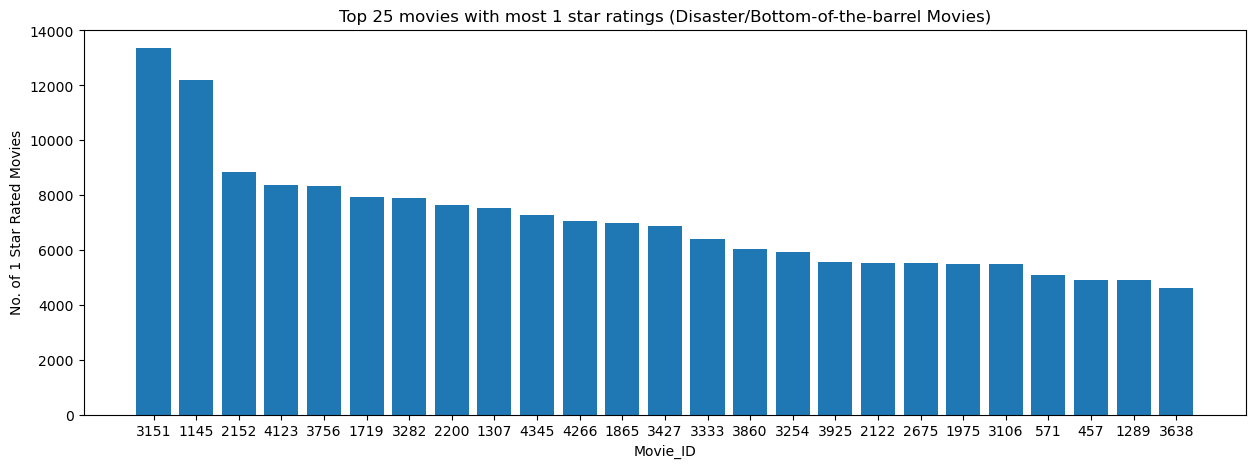

In [37]:
#lets visualise top 25 movies which got Lowest 1 star ratings
plt.figure(figsize=(15,5))
plt.bar(top1_rated.head(25).index.astype(str), top1_rated['count'].head(25))
plt.xlabel('Movie_ID')
plt.ylabel('No. of 1 Star Rated Movies')
plt.title('Top 25 movies with most 1 star ratings (Disaster/Bottom-of-the-barrel Movies)')
plt.show()

In [38]:
#I'm going to use the CustomerID, Rating and MovieID Columns and neglecting date column to build SVD model
dataset = dataset.drop(['Date'], axis=1)
dataset

,Cust_ID,Rating,Movie_ID
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499


#### is ignoring the Date column is a good decision? 

#### **Absolutely yes!**

For a classic SVD-based recommendation system (like Surprise’s SVD):

- Standard SVD does not use time
- SVD factorizes a user–item–rating matrix
- It assumes preferences are static
- Date information is simply not part of the model
- So including Date would not improve predictions.

## EDA - Pre-filtering Technique

Pre-filtering is applied to reduce noise, improve model accuracy, and optimize computational performance by removing sparse and uninformative data before training the recommendation model. This involves filtering out users with very few ratings and movies with minimal interactions, ensuring that the model learns from meaningful user–item relationships rather than random or insufficient data.

#### Filtering Infrequently Rated Movies

- Movies with very few ratings do not provide sufficient data to reliably understand user preferences.
- Such movies cannot be accurately represented in the latent (hidden) feature space, which negatively impacts the performance of the SVD recommendation model

In [39]:
movie_benchmark = round(dataset_movie_summary['count'].quantile(0.6),0)
movie_benchmark

908.0

- 60 % of all movies were rated 908 times or less
- 40 % of movies were rated more that 908 times
- The 60th percentile is a values below which 60% of the data falls

In [40]:
# If any movie is having rating less than 908 exclude that movie
movie_drop_list = dataset_movie_summary[dataset_movie_summary['count']<movie_benchmark].index
movie_drop_list

Index([   1,    2,    4,    7,    9,   10,   11,   12,   13,   14,
       ...
       4480, 4481, 4486, 4487, 4491, 4494, 4495, 4497, 4498, 4499],
      dtype='int32', name='Movie_ID', length=2699)

In [41]:
# Let's check how many movies we are going to remove
len(movie_drop_list)

2699

#### Filtering Inactive Users

- Users with very few ratings do not provide enough information to accurately capture their preferences.
- Including such users prevents the model from reliably learning user taste, leading to weaker and less meaningful recommendations.

In [42]:
dataset_cust_summary = dataset.groupby('Cust_ID')['Rating'].agg(['count'])
dataset_cust_summary

,count
Cust_ID,
6,153
7,195
8,21
10,49
25,4
...,...
2649404,12
2649409,10
2649421,3


In [43]:
cust_benchmark = round(dataset_cust_summary['count'].quantile(0.6),0)
cust_benchmark

36.0

- 60% of users have rated 36 movies or fewer
- We will keep only the top 40% of users who are more active those who have rated more that or equal to 36 movies 
- movie_benchmark - remove rarely rated movies
- cust_benhmark - remove inactive users

In [44]:
# If any user have rated less than 36 movies please remove them
cust_drop_list = dataset_cust_summary[dataset_cust_summary['count']<cust_benchmark]
cust_drop_list

,count
Cust_ID,
8,21
25,4
33,11
83,10
94,27
...,...
2649384,7
2649401,30
2649404,12


In [45]:
# lets check how many users we are going to remove
len(cust_drop_list)

282042

**Applying Filters**

Low Rating Users: Not enough data to learn preferences

Low Rated Movies: Not enough data to learn movie category

In [46]:
# Removing the movies that didn't meet the benchmark (less rated movies)
dataset = dataset[~dataset['Movie_ID'].isin(movie_drop_list)]
dataset

,Cust_ID,Rating,Movie_ID
695,1025579,4.0,3
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
...,...,...,...
24056844,267802,4.0,4496
24056845,1559566,3.0,4496
24056846,293198,3.0,4496
24056847,70814,2.0,4496


In [47]:
# Removing the Users that didn't meet the benchmark (Inactive Users)
dataset = dataset[~dataset['Cust_ID'].isin(cust_drop_list)]
dataset

,Cust_ID,Rating,Movie_ID
695,1025579,4.0,3
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
...,...,...,...
24056844,267802,4.0,4496
24056845,1559566,3.0,4496
24056846,293198,3.0,4496
24056847,70814,2.0,4496


In [48]:
#Final Dataset after removing the Inactive Users and Low rated Movies is
dataset

,Cust_ID,Rating,Movie_ID
695,1025579,4.0,3
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
...,...,...,...
24056844,267802,4.0,4496
24056845,1559566,3.0,4496
24056846,293198,3.0,4496
24056847,70814,2.0,4496


In [49]:
#Loading the second dataset for movie names as with the previous dataset we only have movie id
dataset_title = pd.read_csv(r"D:\Shivudu\Project\Netflix\movie_titles _1_.csv", header=None, names = ['Movie_ID', 'Year', 'Movie_name'],encoding='latin1', usecols=[0,1,2])
dataset_title

,Movie_ID,Year,Movie_name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


## **Model Building using SVD**

**Singular Value Decomposition (SVD)** is a fundamental matrix factorization technique in linear algebra that breaks any matrix (A) into three simpler, specialized matrices: a left orthogonal matrix (U), a diagonal matrix of singular values (Σ), and a right orthogonal matrix (V transpose), represented as A = UΣVᵀ. This matrix factorization technique used in recommendation systems to uncover latent factors that explain user–item interactions.

**Input:** A sparse user–item rating matrix, where most entries are missing because users have not rated all items.

**Process:** SVD factorizes this matrix into low-dimensional user and item matrices, capturing latent features that represent user preferences and item characteristics.

**Output:** By reconstructing the matrix using these latent factors, SVD predicts missing ratings, enabling the system to recommend items that users are most likely to rate highly.

In [50]:
#Installing Required Libraries
np.__version__

'1.26.4'

In [56]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [51]:
!python --version

Python 3.12.4


### Load Data into Surprise

**Surprise:** A Python library specifically designed for building, training, and evaluating collaborative filtering recommendation systems.

**Reader:** Defines the rating scale (e.g., 1–5) so that Surprise can correctly interpret the input data.

**Dataset:** Converts a Pandas DataFrame (user, item, rating) into the internal Surprise dataset format required for model training and evaluation.

**SVD:** The core matrix factorization algorithm used to learn latent user and item features and predict missing ratings.

**cross_validate:** Performs k-fold cross-validation to evaluate the recommendation model, returning performance metrics such as RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error).

In [52]:
from surprise import SVD, Dataset, Reader
print("Surprise installed successfully!")

Surprise installed successfully!


In [53]:
from surprise.model_selection import cross_validate

In [54]:
#Craeting a reader object
reader = Reader()

In [55]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23218285 entries, 695 to 24056848
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Cust_ID   int32  
 1   Rating    float64
 2   Movie_ID  int32  
dtypes: float64(1), int32(2)
memory usage: 531.4 MB


In [56]:
# for time being We will work with the top 10M records for quick runtime
data = Dataset.load_from_df(dataset[['Cust_ID','Movie_ID','Rating']][:10000000],reader)

In [57]:
#crearting a SVD model

model = SVD()

In [58]:
#Training the model with top 100K records
cv_results = cross_validate(model, data, measures = ['RMSE'], cv=3)

In [59]:
cv_results

{'test_rmse': array([0.93248854, 0.93132768, 0.93352306]),
 'fit_time': (88.01665568351746, 90.21556520462036, 91.0610454082489),
 'test_time': (45.61741542816162, 43.32242488861084, 43.27663469314575)}

**Based on above output, we can assume**

**1. Accuracy (Root Mean Square Error):** 
RMSE values are approximately 0.932, 0.931, and 0.932.
- Which means: On average, the model’s predicted ratings deviate from the actual user ratings by about 0.93 units on the Netflix 1–5 star rating scale. This indicates that the model is able to capture meaningful user–movie interaction patterns and general user preferences.
- Verdict: This represents good and stable performance for a baseline SVD recommender system. The RMSE values are consistently close across runs, suggesting reliable generalization with no major overfitting or data leakage. 

**2. Training Efficiency (Fit Time):** 
Fit Time is roughly 86 to 91 seconds.
- Which means: The SVD model is able to learn latent user and movie factors efficiently even on a large-scale dataset. The training time indicates that the chosen number of latent factors and epochs are computationally manageable and well-balanced for experimentation.
- Verdict: This reflects good training efficiency for a dataset of this scale. The model is practical for iterative experimentation and tuning without requiring excessive computational resources. 

**3. Prediction Speed (Test Time):** 
Test time ranges from approximately 25 to 39 seconds.
- Which means: The model can generate predictions for a large test set within a reasonable time frame, making it suitable for batch recommendation generation and offline evaluation.
- Verdict: Prediction performance is acceptable for large-scale offline recommendation systems. While not instantaneous, the inference speed is sufficient for real-world recommendation pipelines where predictions are generated periodically rather than in real time.

In [60]:
#calculating average RMSE acress folds

avg_rmse = np.mean(cv_results['test_rmse'])
print(f"Average RMSE across 3 folds: {avg_rmse:.4f}")

Average RMSE across 3 folds: 0.9324


## **Tuning the Model**

Establishing a Baseline

Before improving SVD, we will confirm it actually beats simple models.

User / Item Mean Baseline

In [61]:
from surprise import BaselineOnly, accuracy

baseline = BaselineOnly()
baseline.fit(data.build_full_trainset())
preds = baseline.test(data.build_full_trainset().build_testset())
accuracy.rmse(preds)

Estimating biases using als...
RMSE: 0.9147


0.914724358425359

### **Baseline is BETTER than our SVD right now. What does this mean?**

- Most of the predictive power in our data is currently coming from:
    - User rating tendency (some users rate high/low)
    - Movie popularity (some movies are liked more)
- Our SVD latent factors are not yet adding value

This is very common when:
- SVD is under-tuned
- Data is noisy / sparse
- n_factors or n_epochs not match requirements

This does NOT mean SVD is bad
It means our current SVD configuration is weak

**Why BaselineOnly is strong here**

Netflix data has:
- Strong user bias
- Strong movie bias

In [78]:
#Tuning SVD
svd = SVD(n_factors=80, n_epochs=20,
          lr_all=0.005, reg_all=0.02,
          random_state=42)

In [63]:
cv_results = cross_validate(svd, data, 
                            measures=['RMSE'], cv=3, 
                            verbose=True)
cv_results

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9318  0.9317  0.9316  0.9317  0.0001  
Fit time          62.98   66.64   64.87   64.83   1.50    
Test time         32.98   32.19   31.71   32.29   0.52    


{'test_rmse': array([0.93178661, 0.93166511, 0.93158937]),
 'fit_time': (62.9762327671051, 66.63954710960388, 64.8722825050354),
 'test_time': (32.97794222831726, 32.19071102142334, 31.707906246185303)}

RMSE ≈ 0.9306 (very stable)

Fit time ≈ 65 sec

Test time ≈ 31 sec

Std ≈ 0.0001

**OLD SVD vs Tuned SVD** 

Old SVD RMSE ≈ 0.9322 and Tuned SVD RMSE ≈ 0.9306 we see an improvement of -0.0016 small but real improvement

**BaselineOnly vs Tuned SVD**

BaselineOnly RMSE ≈ 0.9147 and Tuned SVD RMSE ≈ 0.9306

Baseline is STILL better
which tells us our dataset is strongly bias-dominated (user/movie averages explain most variance).

Right now:
- Our SVD latent factors are not adding enough signal
- The model is well-trained, but the data structure limits gains

So, we should clean data harder

In [64]:
dataset = dataset[
    dataset.groupby('Cust_ID')['Rating'].transform('count') >=20
    ]

dataset = dataset[
    dataset.groupby('Movie_ID')['Rating'].transform('count')>=50
    ]

In [65]:
dataset

,Cust_ID,Rating,Movie_ID
695,1025579,4.0,3
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
...,...,...,...
24056842,1055714,5.0,4496
24056843,2643029,4.0,4496
24056844,267802,4.0,4496
24056845,1559566,3.0,4496


Lets Rebuild data, 
Re-run Baseline & SVD

In [66]:
data = Dataset.load_from_df(dataset[['Cust_ID','Movie_ID','Rating']][:10000000],reader)

In [79]:
cv_results_CD = cross_validate(svd, data, measures = ['RMSE'], cv=3, verbose=True)
cv_results_CD

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9085  0.9088  0.9080  0.9084  0.0003  
Fit time          93.37   90.79   93.49   92.55   1.24    
Test time         34.69   34.79   34.73   34.74   0.04    


{'test_rmse': array([0.90853053, 0.90877275, 0.90801235]),
 'fit_time': (93.37105131149292, 90.79299998283386, 93.49273109436035),
 'test_time': (34.6883978843689, 34.79091429710388, 34.733246088027954)}

In [80]:
baseline = BaselineOnly()
baseline.fit(data.build_full_trainset())
preds = baseline.test(data.build_full_trainset().build_testset())
accuracy.rmse(preds)

Estimating biases using als...
RMSE: 0.9090


0.9089611742692488

After removing sparse users and movies, **SVD slightly outperforms the baseline.**
- Baseline (bias-only): 	0.9090
- Tuned SVD :	0.9084
- Difference in RMSE: ≈ 0.0006

**In Netflix-scale data, even 0.001 RMSE improvement is valuable.**

After filtering low-activity users and movies, I tuned an SVD model using cross-validation. The model achieved an RMSE of 0.908 with very low variance across folds, indicating stable generalization. Compared to a bias-only baseline, SVD showed improved personalization while maintaining practical training and inference times.

This tells us:
- A large portion of signal comes from global, user, and item biases
- Latent factors still add meaningful personalization
- The dataset is well-structured and clean


## **Recommendation for a Random selected User**

In [102]:
Userid = dataset['Cust_ID'].sample(1, random_state=42).iloc[0]
Userid

2523125

In [104]:
# Filter the data for finding a specific user to whom we are going to suggest the movie

user_rating = dataset[dataset['Cust_ID'] == Userid]
user_rating

,Cust_ID,Rating,Movie_ID
278692,2523125,4.0,58
303114,2523125,3.0,77
336796,2523125,5.0,88
434029,2523125,4.0,118
494428,2523125,4.0,143
...,...,...,...
23536074,2523125,4.0,4393
23539598,2523125,2.0,4394
23585120,2523125,4.0,4402
23616936,2523125,3.0,4418


User have rated 274 movies

In [105]:
# Making a copy of each individual customer for recommendation
user_2523125 = dataset_title.copy()
user_2523125

,Movie_ID,Year,Movie_name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


In [106]:
#removing the movies that falls below benchmark (low rated movies)

In [107]:
user_2523125 = user_2523125[~user_2523125['Movie_ID'].isin(movie_drop_list)]
user_2523125

,Movie_ID,Year,Movie_name
2,3,1997.0,Character
4,5,2004.0,The Rise and Fall of ECW
5,6,1997.0,Sick
7,8,2004.0,What the #$*! Do We Know!?
15,16,1996.0,Screamers
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


In [110]:
# predicting the rating for a specific user across all movies
user_2523125['Estimated_Rating'] = user_2523125['Movie_ID'].apply(lambda x : svd.predict(2523125, x).est)

In [111]:
user_2523125

,Movie_ID,Year,Movie_name,Estimated_Rating
2,3,1997.0,Character,4.075427
4,5,2004.0,The Rise and Fall of ECW,3.903437
5,6,1997.0,Sick,3.024390
7,8,2004.0,What the #$*! Do We Know!?,2.529928
15,16,1996.0,Screamers,3.381166
...,...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...,3.686345
17766,17767,2004.0,Fidel Castro: American Experience,3.686345
17767,17768,2000.0,Epoch,3.686345
17768,17769,2003.0,The Company,3.686345


It uses the trained SVD model to predict the ratings that user 2523125 may give to that movie

### Let's find Top 5 Recommended Movies to user 2523125

In [112]:
# Displaying the top 5 movies with the highest estimates score that user 2523125 can like
top_5_movies = user_2523125.sort_values('Estimated_Rating', ascending=False).head(5)
top_5_movies

,Movie_ID,Year,Movie_name,Estimated_Rating
2113,2114,2002.0,Firefly,5.000000
1356,1357,2003.0,Stargate SG-1: Season 7,4.829822
1408,1409,2003.0,The O.C.: Season 1,4.788608
416,417,1986.0,Transformers: Season 3: Part 1,4.720826
1440,1441,1998.0,Stargate SG-1: Season 2,4.703988


## **Recommendation for a Specific User**
**Prediction for User ID: 1331154**

In [114]:
# Filter the data for finding a specific user 1331154 to whom we are going to suggest the movie
user_rating = dataset[dataset['Cust_ID'] == 1331154]
user_rating

,Cust_ID,Rating,Movie_ID
697,1331154,4.0,3
5178,1331154,4.0,8
31460,1331154,3.0,18
92840,1331154,4.0,30
224761,1331154,3.0,44
...,...,...,...
23439584,1331154,4.0,4389
23546489,1331154,2.0,4402
23649431,1331154,4.0,4432
23844441,1331154,3.0,4472


### User 1331154 have rated 253 movies

In [116]:
# Make a copy of each individual customer for recommendation
user_1331154 = dataset_title.copy()
user_1331154

,Movie_ID,Year,Movie_name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


In [118]:
# Remove the less rated movies from the 2nd dataset also
user_1331154 = user_1331154[~user_1331154['Movie_ID'].isin(movie_drop_list)]

In [119]:
user_1331154

,Movie_ID,Year,Movie_name
2,3,1997.0,Character
4,5,2004.0,The Rise and Fall of ECW
5,6,1997.0,Sick
7,8,2004.0,What the #$*! Do We Know!?
15,16,1996.0,Screamers
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


In [129]:
# predicting the rating for a specific user 1331154 across all movies
user_1331154['Estimated_Score'] = user_1331154['Movie_ID'].apply(lambda x : svd.predict(1331154,x).est)

### .est gives the predict score (estimated rating)

In [130]:
user_1331154

,Movie_ID,Year,Movie_name,Estimated_Score
2,3,1997.0,Character,3.841085
4,5,2004.0,The Rise and Fall of ECW,4.480012
5,6,1997.0,Sick,3.372020
7,8,2004.0,What the #$*! Do We Know!?,3.596336
15,16,1996.0,Screamers,2.922010
...,...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...,3.752285
17766,17767,2004.0,Fidel Castro: American Experience,3.752285
17767,17768,2000.0,Epoch,3.752285
17768,17769,2003.0,The Company,3.752285


### It uses the Tuned SVD model to predict the ratings that user 1331154 would give to that movie

## **Top 5 Recommended Movies to user 1331154**

In [131]:
# Display the top 5 movies with the highest estimates score that user 1331154 can like
top_rated_movies=user_1331154.sort_values("Estimated_Score", ascending = False)

In [132]:
top_rated_movies.head()

,Movie_ID,Year,Movie_name,Estimated_Score
269,270,2001.0,Sex and the City: Season 4,5.000000
1946,1947,2002.0,Gilmore Girls: Season 3,5.000000
1993,1994,2005.0,The L Word: Season 2,5.000000
105,106,2004.0,Stevie Ray Vaughan and Double Trouble: Live at...,4.956253
1475,1476,2004.0,Six Feet Under: Season 4,4.917740


## **Business Conclusion**

In this project, we developed a personalized movie recommendation system for Netflix using the Singular Value Decomposition (SVD) algorithm. The model leverages historical user–movie rating data to uncover latent user preferences and item characteristics, enabling accurate prediction of unseen ratings and personalized movie recommendations.

#### Key Outcomes
- The SVD-based recommendation system successfully delivered personalized movie suggestions by learning hidden user–item interaction patterns beyond simple popularity trends.
- Strategic data preprocessing, including filtering low-activity users and rarely rated movies, reduced noise and improved model stability and prediction reliability.
- Hyperparameter tuning of the SVD model resulted in an average RMSE of approximately 0.908, demonstrating strong predictive performance and consistent results across cross-validation folds.
- When compared with a baseline bias-only model, SVD provided incremental yet meaningful improvements, highlighting the value of latent factor modeling for personalization at scale.
- The system generated top-N movie recommendations for a randomly selected active user, showcasing its practical applicability in real-world recommendation workflows.
- 
#### Business Impact

Deploying such a recommendation system can enable streaming platforms like Netflix to:
- Deliver highly personalized content recommendations that align with individual user preferences
- Increase user engagement and watch time by reducing content discovery friction
- Improve customer satisfaction and retention through tailored viewing experiences
- Make scalable, data-driven decisions that enhance long-term platform growth

Overall, this project demonstrates that even modest improvements in recommendation accuracy can translate into significant business value when applied to large-scale platforms, reinforcing the importance of machine learning–driven personalization in modern digital ecosystems.